**EEGBCI Sensorimotor Dynamics - multi‑subject motor ERD & ERP analysis**

Dataset: MNE-EEGBCI, Subjects 3-11, run 3 (open and close left or right fist)

This is an extension of the previous single-subject analysis of the MNE-EEGBCI Motor Movement/Imagery Dataset by scaling the pipeline to multiple subjects.

It preserves the original preprocessing, ERD, and ERP methodology while introducing modularity for consistent processing across participants and enabling group-level inferences and statistical validation of the previously observed trends.

Previous single-subject hypotheses were extended to a multi-subject analysis to test whether the effects generalize across participants:

H1: Real hand movement (T1/T2) should cause stronger brain rhythm suppression in motor areas (mu/beta ERD) than rest (T0). Tested by comparing ERSPs for movement vs rest over motor areas (C3/C4).

H2: Motor ERPs should show contralateral predominance during the 300–600 ms post-movement window. Measured by comparing amplitudes at contralateral versus ipsilateral electrodes (C3/C4).

**Dataset description**

Participants: 109 healthy subjects

Runs per subject: 14

Current selection: Subject 3-11, run 3

Condition: Open and close left or right fist

The dataset originates from the EEG Motor Movement/Imagery Dataset hosted on PhysioNet:
https://physionet.org/content/eegmmidb/1.0.0/


**Methods:**

1. Data Loading / setup

2. Visualization & QC: Power spectral density

3. Preprocessing: 60 Hz notch filtering, downsampling to 120 Hz, re-inspection

4. ICA: Setting montage, ICA, automated EOG detection & removal

5. Epoching: Segmentation into rest (T0), left-hand (T1), and right-hand (T2) movement epochs (-0.2 to 1.0 s)

6. ERSP / ERD Analysis: Morlet wavelet transform to quantify mu/beta (8-30 Hz) ERD, extracting ERD values for rest and movement

7. ERP Analysis: Evoked potential extraction and contralateral/ipsilateral comparisons

8. Master Loop & Data Validation: Sequential processing of all 8 subjects, validation of obtained data before statistics

9. Plotting & H1 testing: Paired t-test comparing movement vs rest ERD, bar plot

10. Plotting & H2 testing: Paired t-test comparing contralateral/ipsilateral amplitudes, bar plot, Cohen's d

**Analysis reasoning:**

As an extension of the single subject analysis, all commands were expanded into reusable functions to allow scaling, and master processing loop for iterating through all n subjects. Modular design was chosen because it enables scalable multi-subject processing without code duplication.

Single-subject plots were used for quality assurance to verify that the steps performed as expected before batch processing. Group-level plots were subsequently generated to visualize average effects across the sample.

**1. Load / Setup**

(Imports, setting parameters, load function)

In [12]:
# EEG data analysis framework
!pip install mne

# Main imports
import mne
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import warnings
from scipy import stats
from mne.datasets import eegbci
from mne.io import read_raw_edf
from mne.preprocessing import ICA
from mne import Epochs
from mne.time_frequency import tfr_morlet
warnings.filterwarnings('ignore')

%matplotlib inline

# Global parameters
subjects = list(range(3, 11))
runs = [3]
my_path = '/root/mne_data'

Creating a function that takes a subject ID and returns an MNE Raw object containing that subject’s EEG data, instead of manually loading each subject individually:

In [13]:
def load_subject(subj, runs, path):
    file_path = eegbci.load_data(subj, runs, path=path, force_update=False, update_path=False)
    raw = read_raw_edf(file_path[0], preload=True)
    return raw

**2. Visualization & Quality Control QC**

In [14]:
def run_qc_checks(subj, raw, subjects_list):
    if subj in subjects_list[:2]:
        psd = raw.compute_psd(fmin=2, fmax=min(80, raw.info['sfreq']/2))
        fig = psd.plot(average=True, show=False)
        fig.set_size_inches(9, 3)
        plt.show()
        return True
    return False

I will be inspecting power spectral density specifically only on the first 2 subjects to verify data quality, to preserve computational power and for efficiency.

Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S003/S003R03.edf...
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Effective window size : 12.800 (s)
Plotting power spectral density (dB=True).


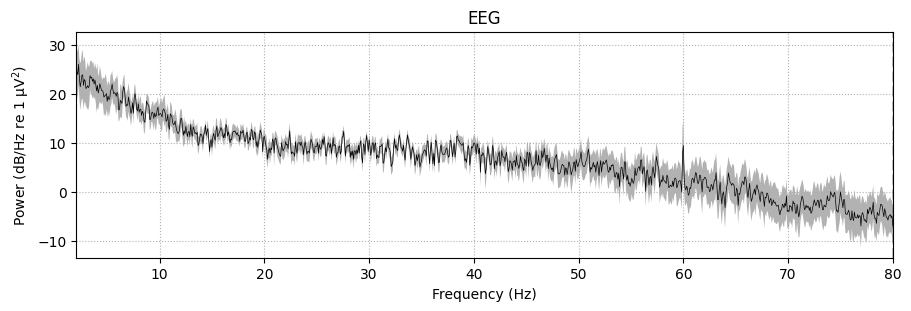

Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S004/S004R03.edf...
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Effective window size : 12.800 (s)
Plotting power spectral density (dB=True).


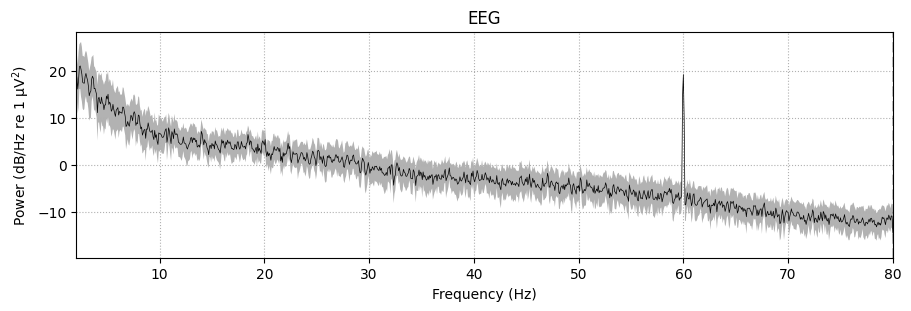

Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S005/S005R03.edf...
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S006/S006R03.edf...
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S007/S007R03.edf...
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S008/S008R03.edf...
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S009/S009R03.edf...
S

In [40]:
for subj in subjects:
    path = eegbci.load_data(subj, runs, path=my_path,
                            force_update=False, update_path=False)
    raw = read_raw_edf(path[0], preload=True)
    run_qc_checks(subj, raw, subjects)

**3. Preprocessing**

(Notch filter, downsampling)

Defining preprocessing function:

In [16]:
def preprocess_raw(raw):
    raw.notch_filter(freqs=60, verbose=False)
    raw.resample(120, npad='auto', verbose=False)
    return raw

Inspecting the first 2 subjects if preprocessing has been successful:

Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S003/S003R03.edf...
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Effective window size : 17.067 (s)
Plotting power spectral density (dB=True).


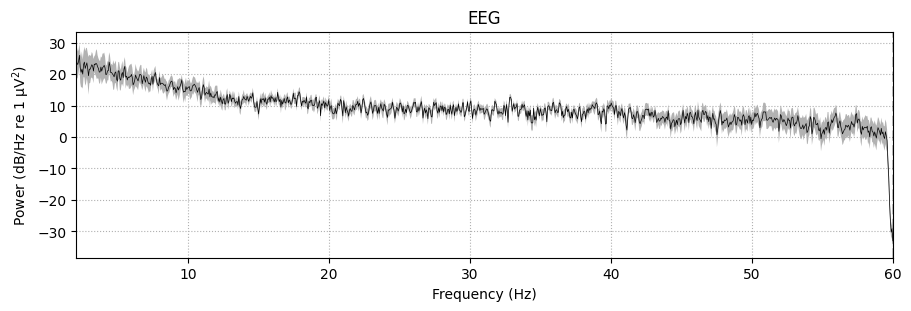

Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S004/S004R03.edf...
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Effective window size : 17.067 (s)
Plotting power spectral density (dB=True).


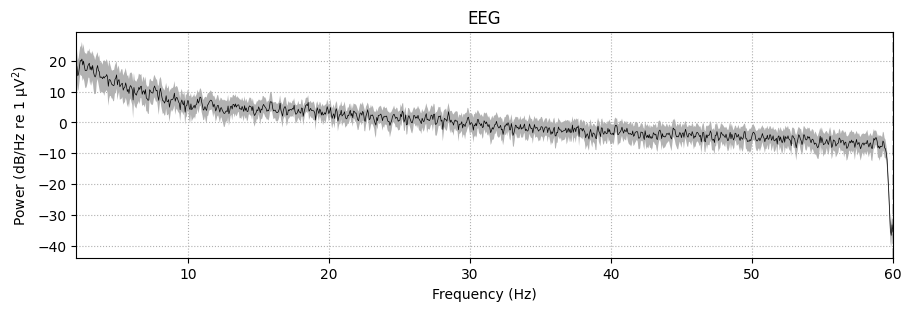

In [17]:
for subj in subjects[:2]:
    path = eegbci.load_data(subj, runs, path=my_path, force_update=False, update_path=False)
    raw = read_raw_edf(path[0], preload=True)
    raw = preprocess_raw(raw)
    run_qc_checks(subj, raw, subjects)

**4. ICA & Component Inspection**

Montage function (10-20 system):

In [18]:
def set_standard_montage(raw):
    montage = mne.channels.make_standard_montage('standard_1020')
    raw.rename_channels(mapping=lambda name: name.replace(".", ""))
    raw.set_montage(montage, match_case=False, verbose=False)
    return raw

I implemented automated EOG correlation to screen the ICA components with frontal channels (Fp1/Fp2), and only the component showing the highest EOG-related correlation was removed. Automated ocular removal was chosen because blinks are frontal, low-frequency (~0.5–4 Hz), and easily separable from beta activity.  

EMG rejection was avoided due to spectral overlap with beta (~10–300 Hz), risking signal loss. ECG artifacts can sometimes be identified without a dedicated channel, but reliable correlation-based automated detection requires a true ECG reference and without it, removal is less robust.

In [19]:
def run_ica_artifact_removal(raw, n_components=20, random_state=97):
    # High-pass filtered copy
    raw_for_ica = raw.copy().filter(l_freq=1., h_freq=None, verbose=False)

    # Fitting ICA
    ica = ICA(n_components=n_components, method='fastica',
              random_state=random_state, verbose=False)
    ica.fit(raw_for_ica, verbose=False)

    # Automated EOG detection
    try:
        eog_inds, _ = ica.find_bads_eog(raw_for_ica, ch_name=['Fp1', 'Fp2'],
                                        threshold=2.5, verbose=False)
    except:
        eog_inds = []

    # Removing only strongest EOG component if found
    ica.exclude = eog_inds[:1]

    # Reconstructing signal
    cleaned_raw = ica.apply(raw, exclude=ica.exclude, verbose=False)

    return cleaned_raw, ica

ICA components visualization (2 Subjects), to inspect the ICA components before automated EOG correlation for verification which ones correspond to eye artifacts (EOG) or other noise and validate if automated component removal functioned correctly.

Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S003/S003R03.edf...
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
ICA components for Subject 3


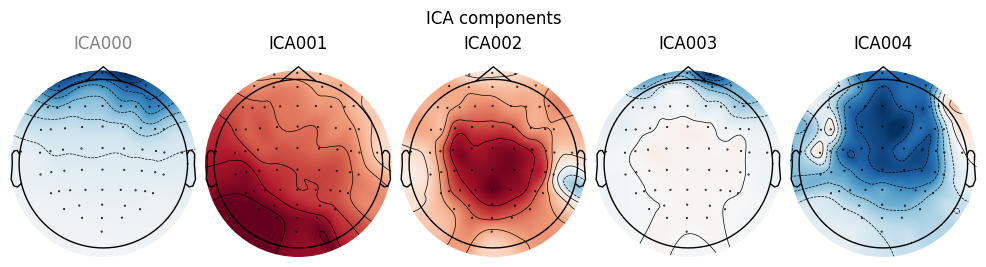

<Figure size 640x480 with 0 Axes>

Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S004/S004R03.edf...
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
ICA components for Subject 4


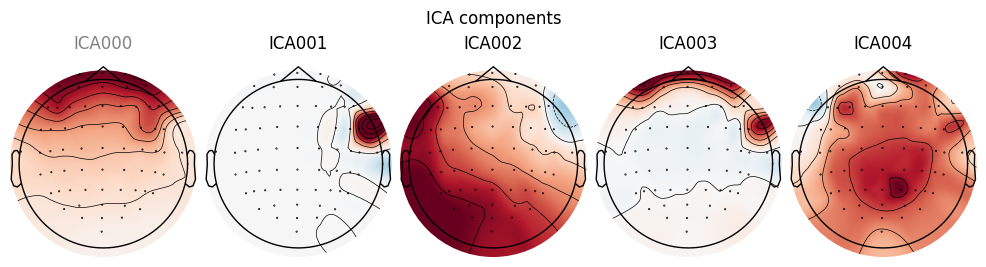

<Figure size 640x480 with 0 Axes>

In [20]:
def plot_ica_components(ica, subj):
    print(f"ICA components for Subject {subj}")
    ica.plot_components(picks=range(5))
    plt.tight_layout()
    plt.show()

for subj in subjects[:2]:
    raw = load_subject(subj, runs, my_path)
    raw = set_standard_montage(raw)
    cleaned_raw, ica = run_ica_artifact_removal(raw)
    plot_ica_components(ica, subj)

Now I am validating if the first 2 subjects had successfully been processed for EOG artifacts:

In [21]:
for subj in subjects[:2]:
    raw = load_subject(subj, runs, my_path)
    raw = set_standard_montage(raw)
    cleaned_raw, ica = run_ica_artifact_removal(raw)

    print(f"Subject {subj}: Excluded EOG component {ica.exclude}")

Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S003/S003R03.edf...
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Subject 3: Excluded EOG component [np.int64(0)]
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S004/S004R03.edf...
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Subject 4: Excluded EOG component [np.int64(0)]


ICA000 [np.int64(0)] EOG component was automatically identified and removed in both subjects.

**5. Epoching**

Defining epoching function.

In [22]:
def create_epochs(raw):
    events_from_annot, event_dict = mne.events_from_annotations(raw, verbose=False)

    epochs = mne.Epochs(
        raw,
        events_from_annot,
        event_id={'T0': 1, 'T1': 2, 'T2': 3},
        tmin=-0.2,
        tmax=1.0,
        baseline=(-0.2, 0),
        preload=True,
        reject_by_annotation=True,
        verbose=False
    )

    return epochs

Note: I applied baseline correction using the pre-stimulus period (-0.2 to 0 s) and identical parameters to single-subject analysis, however I believe skipping the baseline correction would improve results, because of the rapid task design used where each trial follows the previous by ~5 seconds. This means the baseline period may contain residual activity from preceding trials, particularly for Rest epochs (T0) which are preceded by movement.

The choice of preserving baseline correction was made in order to maintain methodological consistency and minimize confounding from introducing major pipeline changes and processing compared to the original within-subject within-run analysis.

**6. Time-Frequency Analysis (ERSP)**

Setting frequency and cycle parameters for Morlet wavelet, defining function:

In [23]:
def get_tfr_params():
    freqs = np.logspace(np.log10(4), np.log10(40), 20)
    n_cycles = freqs / 2
    return freqs, n_cycles

In the single subject analysis, I repeated the same TFR computation 3 times (T0, T1, T2) with inline code; here in multi-subject analysis I wrap it into a  function which computes time-frequency power using Morlet wavelets, applies baseline correction (-0.2 to 0s) using log-ratio, and returns the power object.

In [24]:
def compute_power(epochs_condition, freqs, n_cycles):
    power = epochs_condition.compute_tfr(
        method='morlet',
        freqs=freqs,
        n_cycles=n_cycles,
        use_fft=True,
        return_itc=False,
        average=True,
        verbose=False
    )
    power.apply_baseline((-0.2, 0), mode='logratio', verbose=False)
    return power

QC ERD plots (2 subjects):

Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S003/S003R03.edf...
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
No baseline correction applied
No baseline correction applied
No baseline correction applied


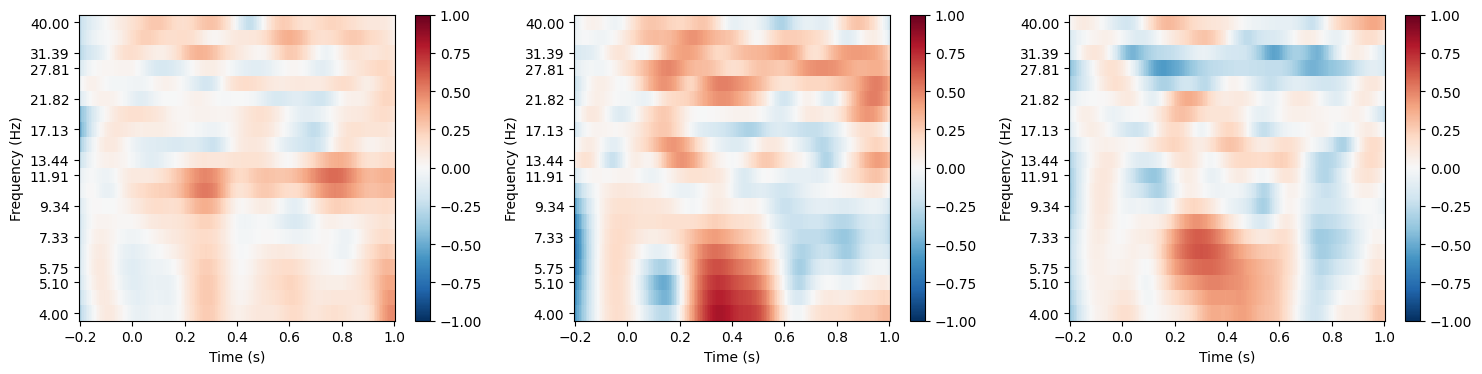

Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S004/S004R03.edf...
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
No baseline correction applied
No baseline correction applied
No baseline correction applied


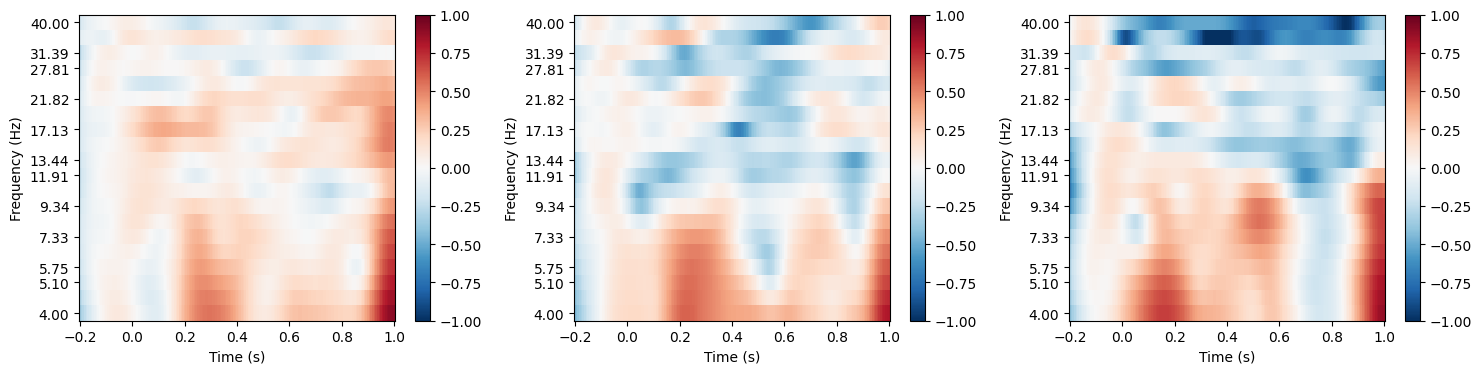

In [25]:
for subj in subjects[:2]:
    raw = load_subject(subj, runs, my_path)
    raw = set_standard_montage(raw)
    raw, _ = run_ica_artifact_removal(raw)
    epochs = create_epochs(raw)

    freqs, n_cycles = get_tfr_params()

    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    compute_power(epochs['T0'], freqs, n_cycles).plot(picks=['C3','C4'], axes=axes[0], combine='mean', show=False, vlim=(-1,1))
    compute_power(epochs['T1'], freqs, n_cycles).plot(picks='C4', axes=axes[1], show=False, vlim=(-1,1))
    compute_power(epochs['T2'], freqs, n_cycles).plot(picks='C3', axes=axes[2], show=False, vlim=(-1,1))
    plt.tight_layout()
    plt.show()

ERD quantification function, extracting values for rest and movement. The original analysis relied on a globally defined frequency vector, but here I extract the frequency values directly from the power object itself using freqs = power_T0.freqs.

In [26]:
def compute_erd_values(power_T0, power_T1, power_T2):

    # Masks
    freqs = power_T0.freqs
    freq_mask = (freqs >= 8) & (freqs <= 30)
    time_mask = (power_T0.times >= 0.2) & (power_T0.times <= 1.0)

    # Channel indices
    c3_idx = power_T0.ch_names.index('C3')
    c4_idx = power_T0.ch_names.index('C4')

    # Extracting C3 / C4 values (T0-T2)
    erd_T0_C3 = np.mean(power_T0.data[c3_idx][freq_mask][:, time_mask])
    erd_T0_C4 = np.mean(power_T0.data[c4_idx][freq_mask][:, time_mask])
    erd_T1_left_C4 = np.mean(power_T1.data[c4_idx][freq_mask][:, time_mask])
    erd_T2_right_C3 = np.mean(power_T2.data[c3_idx][freq_mask][:, time_mask])

    # Combining
    movement_strength = np.mean([erd_T1_left_C4, erd_T2_right_C3])
    rest_strength = np.mean([erd_T0_C4, erd_T0_C3])

    return movement_strength, rest_strength

Extracted values movement_strength and rest_strength will be tested for significance at group level later in the analysis.

**7. Evoked Responses Analysis (ERP)**

Defined avg_amp_epoch function, to extract mean amplitude for a specified channel within a defined time window for each trial, and returns one value per trial.

In [27]:
def avg_amp_epoch(epochs_obj, ch_name, tmin, tmax):
    ch_idx = epochs_obj.ch_names.index(ch_name)
    cropped_data = epochs_obj.copy().crop(tmin, tmax)
    data_array = cropped_data.get_data()
    mean_amps = data_array[:, ch_idx, :].mean(axis=1)
    return mean_amps

Based on the set hypothesis of stronger contralateral than ipsilateral motor cortex activation during unilateral movement, the alternate hypothesis would be true if contralateral amplitudes would be consistently lower (more negative) than ipsilateral amplitudes.

I used different variable names than in the single-subject analysis (renamed to contra / ipsi_left for added clarity.)

Additionally, here in the group-analysis I used the np.mean command to collapse trials into a single number per subject and create 2 lists (contra, ipsi), each with 8 values, whereas in the single-subject analysis I retained each trial, and lateralization was tested separately for each hand using two paired t-tests.

In [28]:
def compute_erp_lateralization(epochs):
    tmin_motor, tmax_motor = 0.3, 0.6

    # Left-hand
    contra_left = np.mean(avg_amp_epoch(epochs['T1'], 'C4', tmin_motor, tmax_motor))
    ipsi_left = np.mean(avg_amp_epoch(epochs['T1'], 'C3', tmin_motor, tmax_motor))

    # Right-hand
    contra_right = np.mean(avg_amp_epoch(epochs['T2'], 'C3', tmin_motor, tmax_motor))
    ipsi_right = np.mean(avg_amp_epoch(epochs['T2'], 'C4', tmin_motor, tmax_motor))

    # Averaging across both hands into 1 contra / ipsi value
    contra = np.mean([contra_left, contra_right]) # C4(left) + C3(right)
    ipsi = np.mean([ipsi_left, ipsi_right])  # C3(left) + C4(right)

    return contra, ipsi

Note: I initially considered retaining the original single-subject design and aggregating the 16 resulting p-values (8 subjects x 2 hands) using a meta-analytic approach such as Fisher's method. However, I opted instead to compute a single contralateral and ipsilateral value per subject by averaging across both hands. This approach was chosen as it provides greater statistical power by testing lateralization directly at the group level with one paired t-test across all subjects.

**8. Master Loop & Data Validation**

Im creating an empty results dictionary that serves as the central data repository for the entire multi-subject analysis.

In [29]:
results = {
    'subject_ids': [],
    'erd_movement': [],
    'erd_rest': [],
    'erp_contra': [],
    'erp_ipsi': []
}

Im now building a single function that takes a subject number, runs them through the entire pipeline end-to-end, and returns their ERD and ERP results  so they can be collected in the results dictionary.

In [30]:
def process_one_subject(subj, runs, path, subjects_list):

    raw = load_subject(subj, runs, path)

    raw = preprocess_raw(raw)

    raw = set_standard_montage(raw)

    raw, ica = run_ica_artifact_removal(raw)

    epochs = create_epochs(raw)

    freqs, n_cycles = get_tfr_params()

    power_T0 = compute_power(epochs['T0'], freqs, n_cycles)
    power_T1 = compute_power(epochs['T1'], freqs, n_cycles)
    power_T2 = compute_power(epochs['T2'], freqs, n_cycles)

    movement_strength, rest_strength = compute_erd_values(power_T0, power_T1, power_T2)

    contra, ipsi = compute_erp_lateralization(epochs)

    return {
        'subject': subj,
        'erd_movement': movement_strength,
        'erd_rest': rest_strength,
        'erp_contra': contra,
        'erp_ipsi': ipsi
    }

Note: Unlike the single-subject analysis which kept both raw and raw_post_ica, here I overwrite the raw variable after ICA to conserve memory as the original data is no longer needed once ICA artifact removal is complete and verified.

Now I will be looping the function 8 times, processing each subject:


In [31]:
for subj in subjects:
    subj_results = process_one_subject(subj, runs, my_path, subjects)
    results['subject_ids'].append(subj_results['subject'])
    results['erd_movement'].append(subj_results['erd_movement'])
    results['erd_rest'].append(subj_results['erd_rest'])
    results['erp_contra'].append(subj_results['erp_contra'])
    results['erp_ipsi'].append(subj_results['erp_ipsi'])

Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S003/S003R03.edf...
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S004/S004R03.edf...
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S005/S005R03.edf...
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S006/S006R03.edf...
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S007/S007R03.edf...
S

Running a validation check before any statistical analysis to confirm everything executed correctly:

In [32]:
df_check = pd.DataFrame(results)
print(df_check)

   subject_ids  erd_movement  erd_rest    erp_contra      erp_ipsi
0            3      0.029777  0.104400  6.250398e-06  1.198030e-05
1            4     -0.103491  0.109999  5.194776e-06  1.893901e-05
2            5     -0.082066  0.201216 -1.669263e-06  1.776452e-07
3            6     -0.126502 -0.068144 -4.038294e-07  8.091792e-06
4            7     -0.125644  0.143634 -8.250611e-06  4.662378e-09
5            8      0.117033  0.063567 -1.916298e-05 -1.166424e-06
6            9     -0.014064 -0.054649  3.981198e-06  2.926264e-05
7           10     -0.010461  0.153206  3.899673e-05  3.713453e-05


The raw printout shows erp_contra and erp_ipsi values are in scientific notation (e-05 to e-09), meaning the data is likely displayed in volts. I will be converting these values from volts to microvolts, x1e6:

In [33]:
df = pd.DataFrame(results)
print("(ERD in dB, ERP in µV)")

df_display = df.copy()
df_display['erp_contra'] = df_display['erp_contra'] * 1e6
df_display['erp_ipsi'] = df_display['erp_ipsi'] * 1e6

print(df_display.round(3))
print()

(ERD in dB, ERP in µV)
   subject_ids  erd_movement  erd_rest  erp_contra  erp_ipsi
0            3         0.030     0.104       6.250    11.980
1            4        -0.103     0.110       5.195    18.939
2            5        -0.082     0.201      -1.669     0.178
3            6        -0.127    -0.068      -0.404     8.092
4            7        -0.126     0.144      -8.251     0.005
5            8         0.117     0.064     -19.163    -1.166
6            9        -0.014    -0.055       3.981    29.263
7           10        -0.010     0.153      38.997    37.135



**9. Plotting & H1 testing**

H1: Real hand movement (T1/T2) should cause stronger brain rhythm suppression in motor areas (mu/beta ERD) than rest (T0). Tested by comparing ERSPs for movement vs rest over motor areas (C3/C4).

The within-subject analysis calculated a single difference value for one subject and used no statistical test for H1. In contrast, here I compute the mean ERD during movement and rest, standard error of the means, difference across all 8 subjects, and use a paired t-test to determine statistical significance.

In [36]:
t_erd, p_erd = stats.ttest_rel(df['erd_movement'], df['erd_rest'])

mean_mov = np.mean(df['erd_movement'])
mean_rest = np.mean(df['erd_rest'])
sem_mov = np.std(df['erd_movement'], ddof=1) / np.sqrt(len(df))
sem_rest = np.std(df['erd_rest'], ddof=1) / np.sqrt(len(df))

print("H1: Mu/Beta ERD (8-30Hz) - Movement vs Rest")
print(f"Movement ERD: {mean_mov:.3f} ± {sem_mov:.3f} dB")
print(f"Rest ERD:     {mean_rest:.3f} ± {sem_rest:.3f} dB")
print(f"Difference:   {mean_mov - mean_rest:.3f} dB")
print(f"Paired t-test: t({len(df)-1}) = {t_erd:.3f}, p = {p_erd:.4f}")

if p_erd < 0.05:
    print("Movement ERD < Rest ERD")
else:
    print("Movement ERD = Rest ERD")

H1: Mu/Beta ERD (8-30Hz) - Movement vs Rest
Movement ERD: -0.039 ± 0.030 dB
Rest ERD:     0.082 ± 0.034 dB
Difference:   -0.121 dB
Paired t-test: t(7) = -2.601, p = 0.0354
Movement ERD < Rest ERD


Paired t-test t(7) revealed a t value of -2.601, and the critical t-value for executed test, under a = 0.05 and df = 7, is  ±2.365. Two-tailed test was chosen since it is the scientific standard, more conservative (harder to get significance), and doesn't ignore effects in the opposite direction.

P value was  p = 0.035, which revealed a significantly stronger event-related desynchronization (ERD) during movement (mean = -0.039 dB) compared to rest (mean = 0.082 dB; t(7) = -2.601, p = 0.035). The results statistically support the H1 hypothesis of stronger brain rhythm suppression in motor areas (mu/beta ERD).

I will be visualizing the obtained results by creating a bar plot comparing mean ERD during rest and movement with error bars representing SEM:

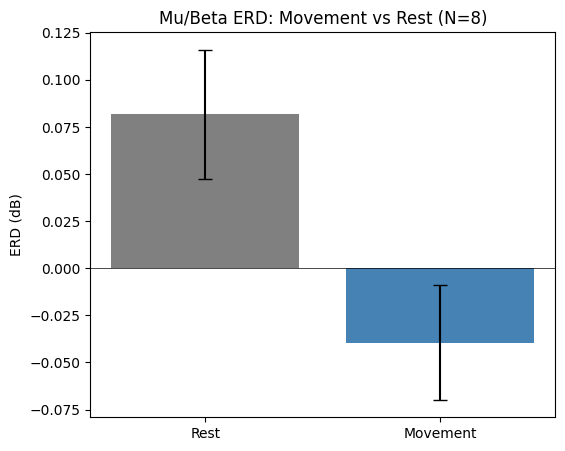

In [37]:
plt.figure(figsize=(6, 5))
x = ['Rest', 'Movement']
means = [mean_rest, mean_mov]
sems = [sem_rest, sem_mov]
plt.bar(x, means, yerr=sems, capsize=5, color=['gray', 'steelblue'])
plt.ylabel('ERD (dB)')
plt.title('Mu/Beta ERD: Movement vs Rest (N={})'.format(len(df)))
plt.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
plt.show()

Negative values on the bar plot indicate event-related desynchronization (power decrease) relative to baseline, while positive indicate synchronization. Rest showed a mean ERD of 0.082 ± 0.034 dB, whereas movement had a negative deflection of -0.039 ± 0.030 dB. The relatively small standard errors indicate that our sample means are precise estimates of the true population means.

The non-overlapping standard errors of the mean for Rest and Movement visually support the statistical finding that movement induces significantly stronger mu/beta suppression than rest (p = 0.035).

**10. Plotting & H2 testing**

H2: Motor ERPs should show contralateral predominance during the 300–600 ms post-movement window. Measured by comparing amplitudes at contralateral versus ipsilateral electrodes (C3/C4).

I test lateralization directly at the group level with a single paired t-test on the subject-averaged contralateral and ipsilateral values, and convert the results to microvolts:

In [38]:
t_erp, p_erp = stats.ttest_rel(df['erp_contra'], df['erp_ipsi'])

mean_contra = np.mean(df['erp_contra']) * 1e6
mean_ipsi = np.mean(df['erp_ipsi']) * 1e6
sem_contra = np.std(df['erp_contra'], ddof=1) / np.sqrt(len(df)) * 1e6
sem_ipsi = np.std(df['erp_ipsi'], ddof=1) / np.sqrt(len(df)) * 1e6

print("H2: Motor ERP - Contralateral vs Ipsilateral")
print(f"Contralateral: {mean_contra:.3f} ± {sem_contra:.3f} µV")
print(f"Ipsilateral:   {mean_ipsi:.3f} ± {sem_ipsi:.3f} µV")
print(f"Difference:    {mean_contra - mean_ipsi:.3f} µV")
print(f"Paired t-test: t({len(df)-1}) = {t_erp:.3f}, p = {p_erp:.4f}")

diff = df['erp_contra'] - df['erp_ipsi']
cohens_d = np.mean(diff) / np.std(diff, ddof=1)
print(f"Cohen's d: {cohens_d:.3f}")

if p_erp < 0.05:
    print("Contralateral > Ipsilateral")
else:
    print("No significant lateralization")

H2: Motor ERP - Contralateral vs Ipsilateral
Contralateral: 3.117 ± 5.921 µV
Ipsilateral:   13.053 ± 5.073 µV
Difference:    -9.936 µV
Paired t-test: t(7) = -3.193, p = 0.0152
Cohen's d: -1.129
Contralateral > Ipsilateral


 A paired t-test comparing the contralateral and ipsilateral lists revealed a significant difference (t(7) = -3.193, p = 0.015). More negative amplitude indicates stronger contralateral activation, with mean amplitudes being 3.12 µV contralateral vs 13.05 µV ipsilateral.

 This confirms the H2 hypothesis, and indicates stronger cortical activation in the hemisphere opposite to the moving hand, which is consistent with established neurophysiological evidence that voluntary movements are predominantly represented in the contralateral primary motor cortex and premotor areas. Despite the modest sample size (n=8), moderately large effect sizes (d = -1.13) enabled detection of significant lateralization and ERD differences.

Visualizing ERP bar plot, with SEM error bars:

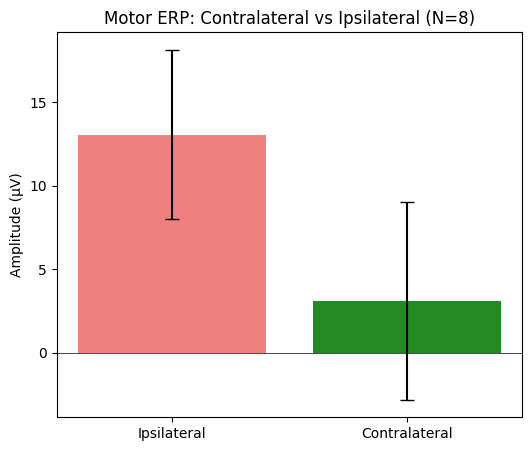

In [39]:
plt.figure(figsize=(6, 5))
x = ['Ipsilateral', 'Contralateral']
means = [mean_ipsi, mean_contra]
sems = [sem_ipsi, sem_contra]
plt.bar(x, means, yerr=sems, capsize=5, color=['lightcoral', 'forestgreen'])
plt.ylabel('Amplitude (µV)')
plt.title('Motor ERP: Contralateral vs Ipsilateral (N={})'.format(len(df)))
plt.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
plt.show()

Result confirm visually that contralateral is significantly more negative than ipsilateral, which is the lateralization effect. The error bars show minimal overlap and this reflects the consistent directional difference observed across subjects.

**Results:**

Multi-subject analysis had significant effects supporting both hypotheses, in contrast to the inconclusive single-subject findings.

1. H1 - ERSP/ERD: Movement elicited significantly stronger mu/beta desynchronization (M = -0.039 dB) compared to rest (M = 0.082 dB), t(7) = -2.601, p = 0.035, d = -1.13, confirming H1 hypothesis.

2. H2 - ERP: Contralateral electrodes showed significantly reduced amplitudes (M = 3.12 µV) relative to ipsilateral electrodes (M = 13.05 µV), t(7) = -3.193, p = 0.015, d = -1.13, confirming the expected lateralization pattern and H2 hypothesis.

We can conclude that the previous weak single-subject findings were due to insufficient power, and thus not detectable rather than absence of true effects.

**Limitations:**

This analysis now includes 8 subjects, which allows for group-level statistics, but the sample size is still relatively small. Individual variability in ERD and ERP responses could influence the averages, so results should be interpreted as indicative rather than definitive.

Comparisons between Movement (T1/T2) and Rest (T0) conditions might still be affected by baseline contamination, as was the case in single-subject analysis. The Rest condition may include residual activity from previous movements, so ERD/ERP differences reflect contrasts relative to the immediate pre-event state rather than a true neutral baseline.

The choice to maintain the baseline in the group-level analysis in order to prevent introducing major pipeline changes and confounding the results.

Although overall there were significant group-level effects observed, the limited number of subjects and trials means the findings should be considered preliminary. Larger samples are needed to fully confirm the robustness and generalizability of contralateral motor activation and ERD patterns.